In [51]:
import os
import sys  
sys.path.insert(1, os.path.abspath('/Users/jonasvvr/Documents/KULeuven/thesis/Soccer-EPV-Framework/LaurieOnTracking/'))

In [52]:
import Metrica_IO as dh
import Metrica_Viz as viz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc

import numpy as np
import matplotlib.pyplot as plt


In [53]:
DATA_DIR = '../sample-data/data'
game_id = 2

In [54]:
event_data = dh.read_event_data(DATA_DIR,game_id)
event_data = dh.to_metric_coordinates(event_data)

home_events = event_data[event_data['Team'] == 'Home']
away_events = event_data[event_data['Team'] == 'Away']

home_shots = home_events[home_events['Type'] == 'SHOT']
away_shots = away_events[away_events['Type'] == 'SHOT']

home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')]
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')]

In [55]:
print(len(event_data))
print(event_data[:3])
event_data['Type'].value_counts()

1935
   Team       Type   Subtype  Period  Start Frame  Start Time [s]  End Frame  \
0  Away  SET PIECE  KICK OFF       1           51            2.04         51   
1  Away       PASS       NaN       1           51            2.04         87   
2  Away       PASS       NaN       1          146            5.84        186   

   End Time [s]      From        To  Start X  Start Y  End X  End Y  
0          2.04  Player23       NaN      NaN      NaN    NaN    NaN  
1          3.48  Player23  Player20     0.00     -0.0 -10.60  -0.68  
2          7.44  Player20  Player18    -7.42     -0.0  -6.36  19.04  


PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64

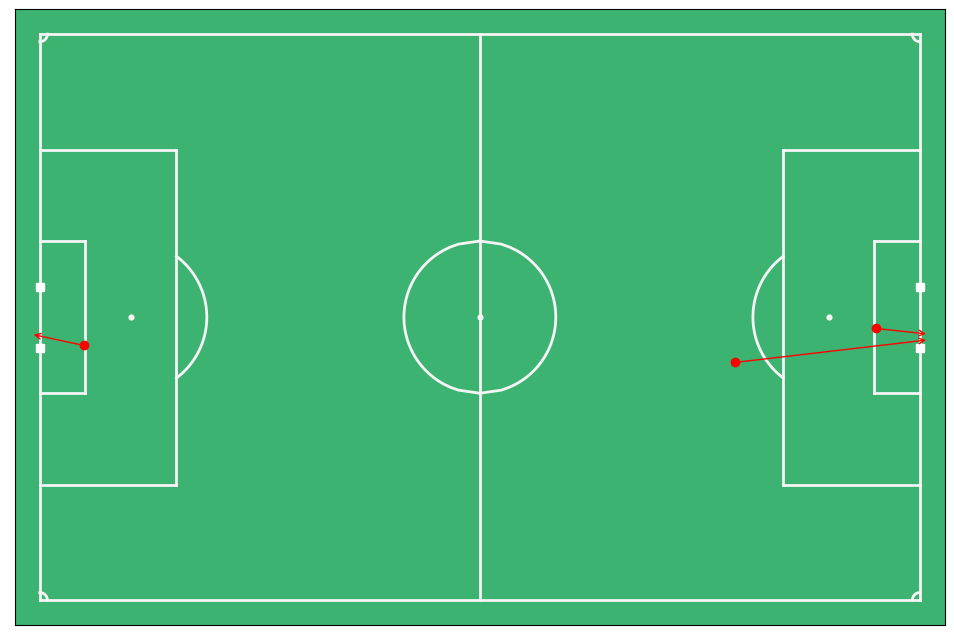

In [56]:
fig,axes = viz.plot_pitch()

for i,goal in home_goals.iterrows():
    axes.plot(goal['Start X'], goal['Start Y'], 'ro')
    axes.annotate('', xy=(goal['End X'], goal['End Y']), xytext=(goal['Start X'], goal['Start Y']), alpha=0.6, arrowprops=dict(arrowstyle='->',color='r'))



(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

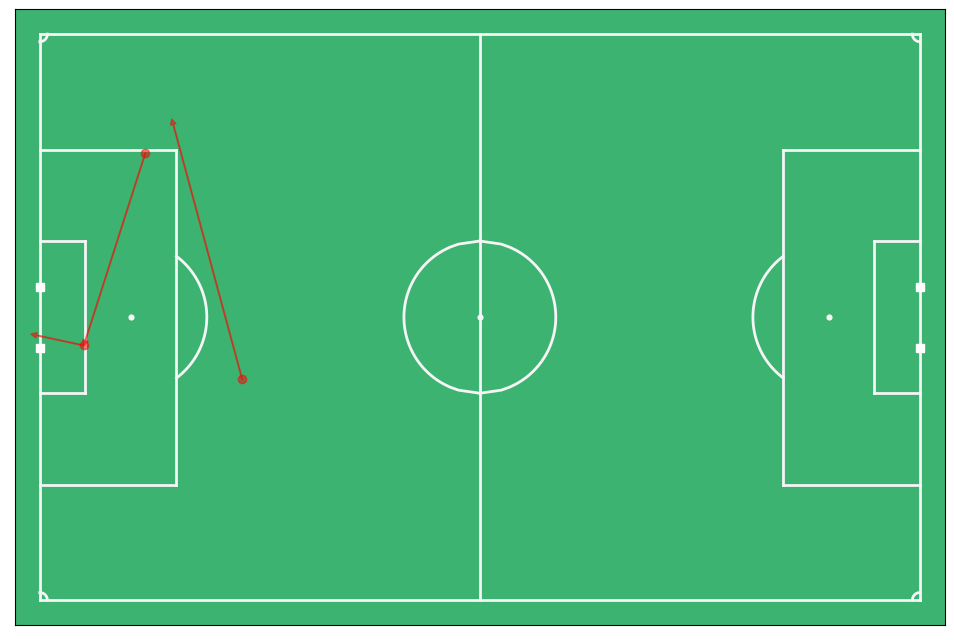

In [57]:
fig1,axes1 = viz.plot_pitch()
goal = home_goals.iloc[0]
idx = home_goals.index[0]
# print(event_data.loc[idx-4:idx])
viz.plot_events(event_data.loc[idx-2:idx], figax=(fig1,axes1), indicators=['Marker','Arrow'])

In [58]:
tracking_home = dh.tracking_data(DATA_DIR, game_id, 'Home')
tracking_away = dh.tracking_data(DATA_DIR, game_id, 'Away')
tracking_home = dh.to_metric_coordinates(tracking_home)
tracking_away = dh.to_metric_coordinates(tracking_away)
tracking_home,tracking_away,events = dh.to_single_playing_direction(tracking_home,tracking_away,event_data)


Reading team: home
Reading team: away


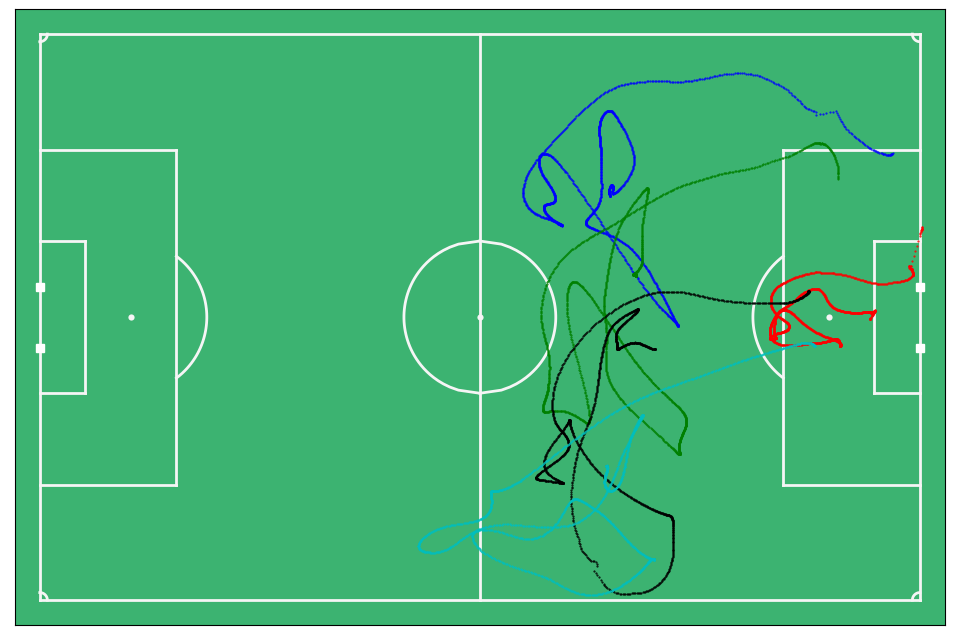

In [59]:
fig,ax = viz.plot_pitch()
ax.plot( tracking_home['Home_11_x'].iloc[:1500], tracking_home['Home_11_y'].iloc[:1500], 'r.', markersize=1)
ax.plot( tracking_home['Home_1_x'].iloc[:1500], tracking_home['Home_1_y'].iloc[:1500], 'b.', markersize=1)
ax.plot( tracking_home['Home_2_x'].iloc[:1500], tracking_home['Home_2_y'].iloc[:1500], 'g.', markersize=1)
ax.plot( tracking_home['Home_3_x'].iloc[:1500], tracking_home['Home_3_y'].iloc[:1500], 'k.', markersize=1)
ax.plot( tracking_home['Home_4_x'].iloc[:1500], tracking_home['Home_4_y'].iloc[:1500], 'c.', markersize=1)

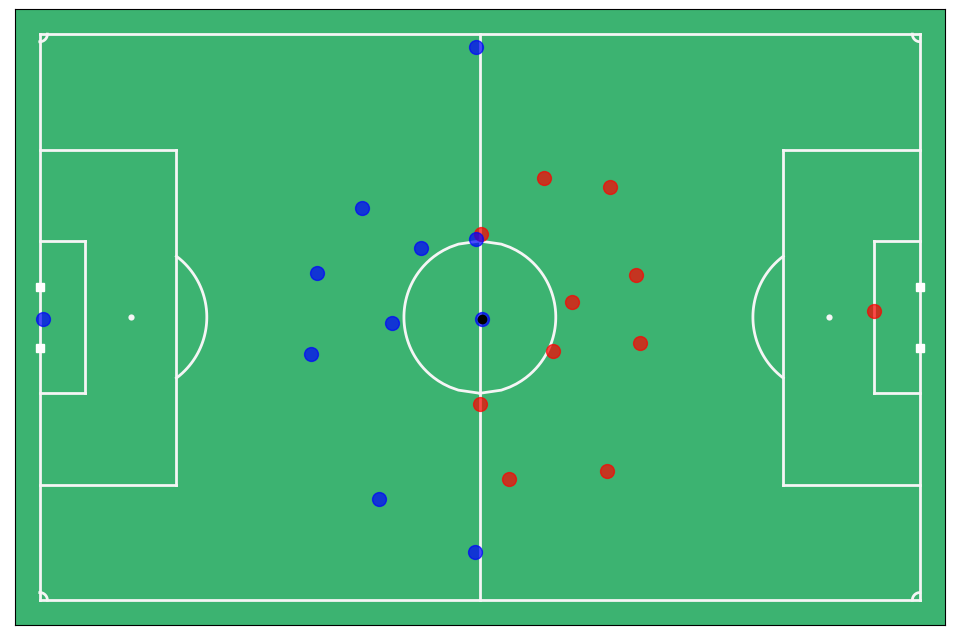

In [60]:
KO_Frame = event_data.loc[0]['Start Frame']
fig,ax = viz.plot_frame( tracking_home.loc[KO_Frame], tracking_away.loc[KO_Frame] )

(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

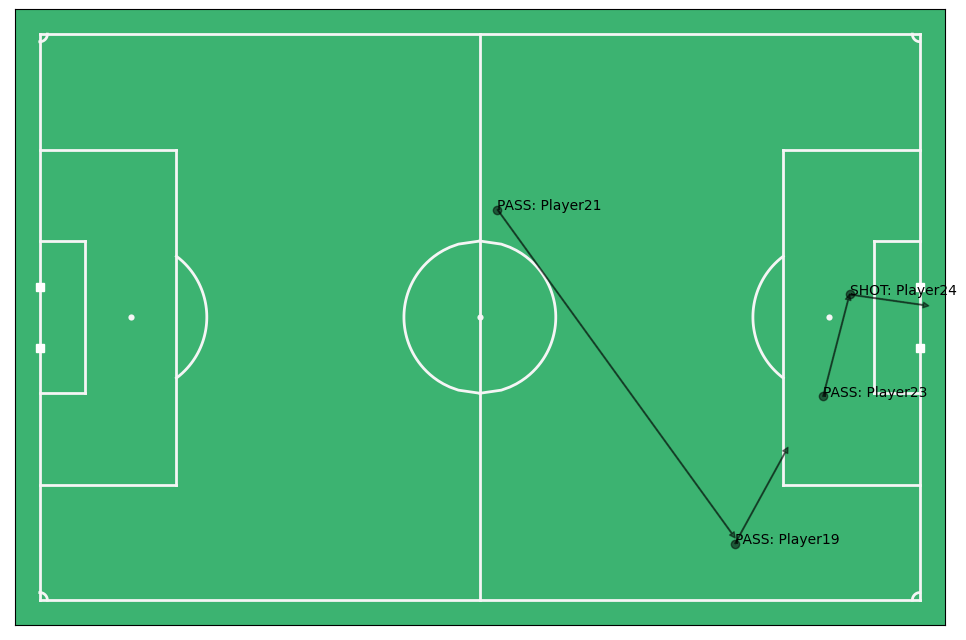

In [61]:
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

viz.plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )

(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

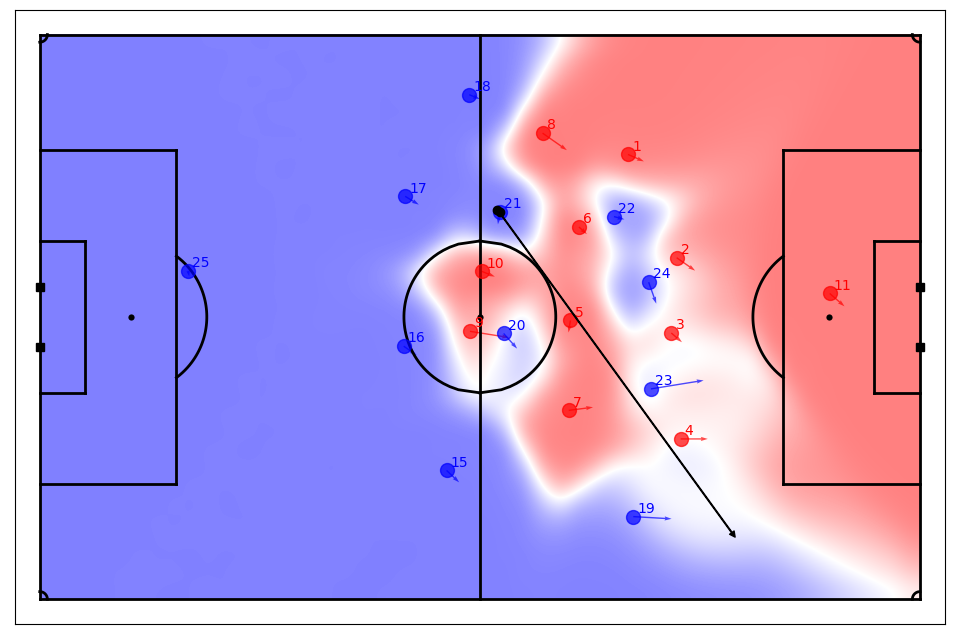

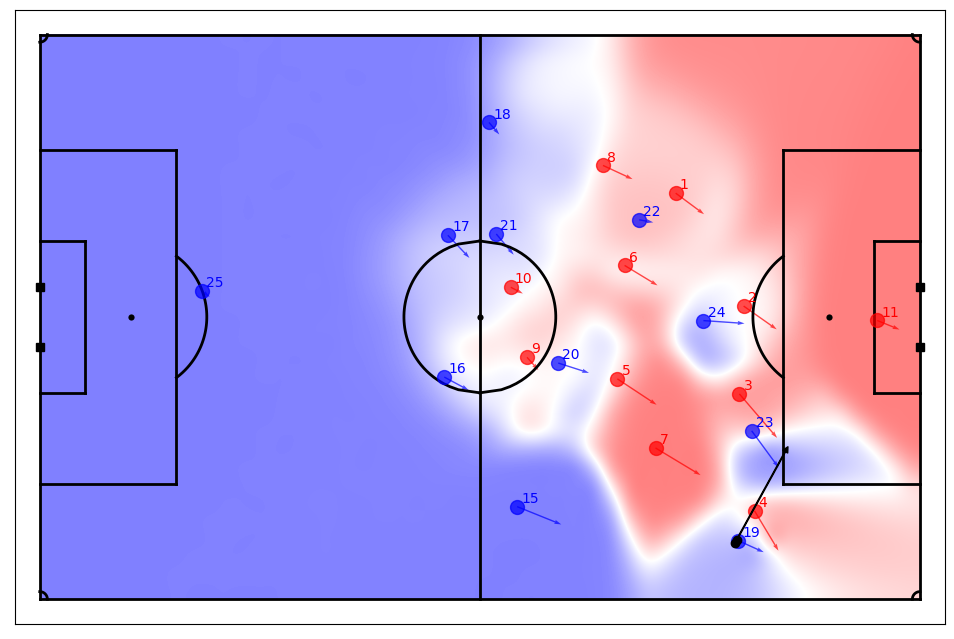

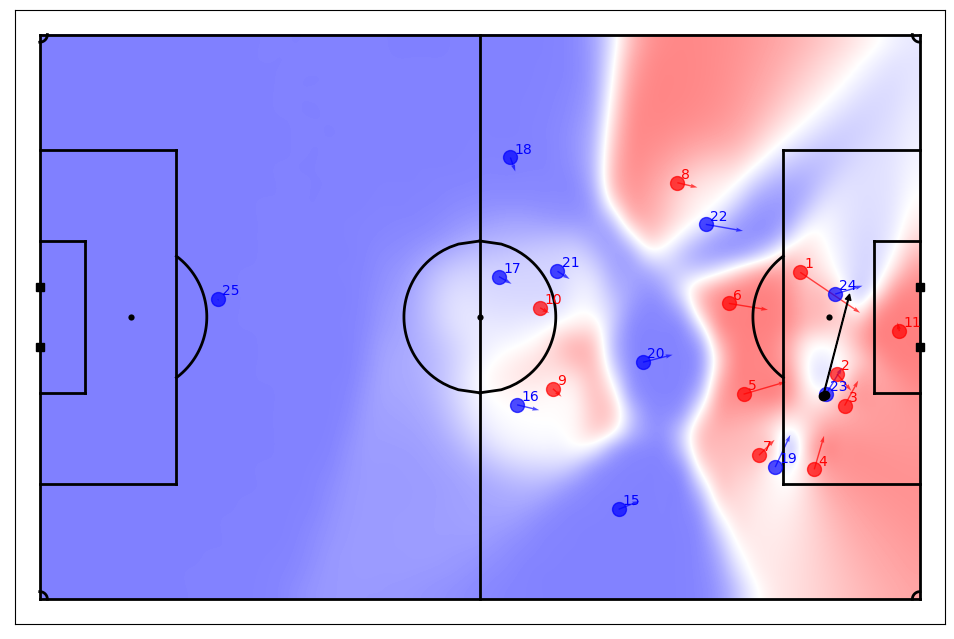

In [62]:
params = mpc.default_model_params()
# find goalkeepers for offside calculation
GK_numbers = [dh.find_goalkeeper(tracking_home),dh.find_goalkeeper(tracking_away)]

PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
viz.plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, annotate=True )
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
viz.plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, annotate=True )
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
viz.plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, annotate=True )

0.9842670305087566


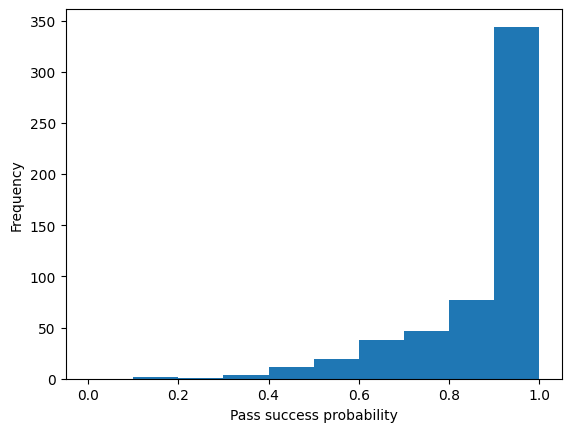

In [66]:
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

# list for storing pass probablities
pass_success_probability = []

for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params, GK_numbers[0])
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params, GK_numbers[1])
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )


fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

assist = events.loc[821]

pass_start_pos = np.array([assist['Start X'],assist['Start Y']])
pass_target_pos = np.array([assist['End X'],assist['End Y']])
pass_frame = assist['Start Frame']

attacking_players = mpc.initialise_players(tracking_home.loc[821],'Home',params, GK_numbers[0])
defending_players = mpc.initialise_players(tracking_away.loc[821],'Away',params, GK_numbers[1])
Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)
print(Patt)


Event following a risky (completed) pass
0.16032323299177256 BALL LOST
0.1613295457364337 CHALLENGE
0.21206157666402695 SHOT
0.31160841865474675 CHALLENGE
0.33190526185319935 SHOT
0.3370434729809066 CHALLENGE
0.3639283907689767 BALL LOST
0.4131562523163675 CHALLENGE
0.42042677463419303 PASS
0.431271262852387 CHALLENGE
0.44435098489184177 CHALLENGE
0.4484489555199406 PASS
0.45936651514837745 CHALLENGE
0.46181533356257215 SHOT
0.4680481708799845 CHALLENGE
0.48972755639125787 CHALLENGE
0.4900872646495709 CHALLENGE
0.4917205100922201 SHOT
0.5001349056944226 PASS
0.5026909720011076 PASS


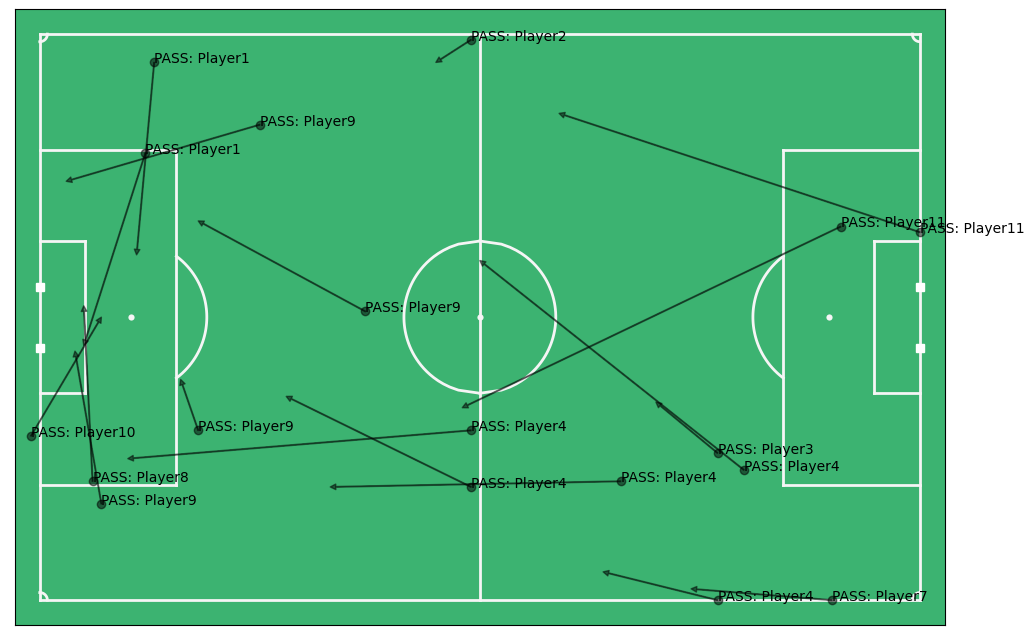

In [64]:
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

# plot the events
viz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )